# AIM: 

We will redock the agonist from a mu-receptor-agonist complex to set a benchmark of affinity for the mu-receptor

Later we will search compound on PubChem to find new agonists.


## PART1: Re-Docking of Receptor-Agonist complex


First we import the needed packages and state the Structure class 

In [10]:

import warnings
from pathlib import Path
import subprocess
import nglview as nv
from openbabel import pybel
from rdkit import Chem
from MDAnalysis import Universe
import numpy as np
import redo


class Structure(Universe):
    """
    Core object to load structures with.

    Thin wrapper around MDAnalysis.Universe objects
    """

    @classmethod
    @redo.retriable(attempts=10, sleeptime=2)
    def from_pdbid(cls, pdbid):
        import mmtf

        return cls(mmtf.fetch(pdbid))

    @classmethod
    def from_string(cls, pdbid_or_path, **kwargs):
        import os

        if os.path.isfile(pdbid_or_path):
            return cls(pdbid_or_path, **kwargs)
        return cls.from_pdbid(pdbid_or_path, **kwargs)

    @classmethod
    def from_atomgroup(cls, *args):
        """Create a new new :class:`Structure` from one or more
        ``AtomGroup`` instances.

        Parameters
        ----------
        *args : ``AtomGroup``
            One or more AtomGroups.

        Returns
        -------
        structure : :class:`Structure`

        Raises
        ------
        ValueError
            Too few arguments or an AtomGroup is empty and
        TypeError
            Arguments are not :class:`AtomGroup` instances.

        Notes
        -----
        This is take straight from ``MDAnalysis.universe``. Refer to that
        module for more information.

        """
        from MDAnalysis.coordinates.memory import MemoryReader
        from MDAnalysis.topology.base import squash_by
        from MDAnalysis.core import groups
        from MDAnalysis.core.topology import Topology
        from MDAnalysis.core.topologyattrs import AtomAttr, ResidueAttr, SegmentAttr

        if len(args) == 0:
            raise ValueError("Need at least one AtomGroup for merging")

        for a in args:
            if not isinstance(a, groups.AtomGroup):
                raise TypeError(repr(a) + " is not an AtomGroup")
        for a in args:
            if len(a) == 0:
                raise ValueError("cannot merge empty AtomGroup")

        # Create a new topology using the intersection of topology attributes
        blank_topology_attrs = set(dir(Topology(attrs=[])))
        common_attrs = set.intersection(*[set(dir(ag.universe._topology)) for ag in args])
        tops = set(["bonds", "angles", "dihedrals", "impropers"])

        attrs = []

        # Create set of attributes which are array-valued and can be simply
        # concatenated together
        common_array_attrs = common_attrs - blank_topology_attrs - tops
        # Build up array-valued topology attributes including only attributes
        # that all arguments' universes have
        for attrname in common_array_attrs:
            for ag in args:
                attr = getattr(ag, attrname)
                attr_class = type(getattr(ag.universe._topology, attrname))
                if issubclass(attr_class, AtomAttr):
                    pass
                elif issubclass(attr_class, ResidueAttr):
                    attr = getattr(ag.residues, attrname)
                elif issubclass(attr_class, SegmentAttr):
                    attr = getattr(ag.segments, attrname)
                else:
                    raise NotImplementedError(
                        "Don't know how to handle"
                        " TopologyAttr not subclassed"
                        " from AtomAttr, ResidueAttr,"
                        " or SegmentAttr."
                    )
                if type(attr) != np.ndarray:
                    raise TypeError(
                        "Encountered unexpected topology "
                        "attribute of type {}".format(type(attr))
                    )
                try:
                    attr_array.extend(attr)
                except NameError:
                    attr_array = list(attr)
            attrs.append(attr_class(np.array(attr_array, dtype=attr.dtype)))
            del attr_array

        # Build up topology groups including only those that all arguments'
        # universes have
        for t in tops & common_attrs:
            offset = 0
            bondidx = []
            types = []
            
            for ag in args:
                # create a mapping scheme for this atomgroup
                mapping = {a.index: i for i, a in enumerate(ag, start=offset)}
                offset += len(ag)

                tg = getattr(ag, t)
                bonds_class = type(getattr(ag.universe._topology, t))
                # Create a topology group of only bonds that are within this ag
                # ie we don't want bonds that extend out of the atomgroup
                tg = tg.atomgroup_intersection(ag, strict=True)

                # Map them so they refer to our new indices
                new_idx = [tuple([mapping[x] for x in entry]) for entry in tg.indices]
                bondidx.extend(new_idx)
                if hasattr(tg, "_bondtypes"):
                    types.extend(tg._bondtypes)
                else:
                    types.extend([None] * len(tg))


            if any(t is None for t in types):
                attrs.append(bonds_class(bondidx))
            
            else:
                types = np.array(types, dtype="|S8")
                attrs.append(bonds_class(bondidx, types))

        # Renumber residue and segment indices
        n_atoms = sum([len(ag) for ag in args])
        residx = []
        segidx = []
        res_offset = 0
        seg_offset = 0
        for ag in args:
            # create a mapping scheme for this atomgroup's parents
            res_mapping = {r.resindex: i for i, r in enumerate(ag.residues, start=res_offset)}
            seg_mapping = {r.segindex: i for i, r in enumerate(ag.segments, start=seg_offset)}
            res_offset += len(ag.residues)
            seg_offset += len(ag.segments)

            # Map them so they refer to our new indices
            residx.extend([res_mapping[x] for x in ag.resindices])
            segidx.extend([seg_mapping[x] for x in ag.segindices])

        residx = np.array(residx, dtype=np.int32)
        segidx = np.array(segidx, dtype=np.int32)

        _, _, [segidx] = squash_by(residx, segidx)

        n_residues = len(set(residx))
        n_segments = len(set(segidx))

        top = Topology(
            n_atoms,
            n_residues,
            n_segments,
            attrs=attrs,
            atom_resindex=residx,
            residue_segindex=segidx,
        )

        # Create and populate a universe
        coords = np.vstack([a.positions for a in args])
        u = cls(top, coords[None, :, :], format=MemoryReader)

        return u

    def write(self, *args, **kwargs):
        # Workaround for https://github.com/MDAnalysis/mdanalysis/issues/2679
        if self.dimensions is None:
            self.trajectory.ts._unitcell = np.zeros(6)
        return self.atoms.write(*args, **kwargs)

In [3]:
# filter warnings
warnings.filterwarnings("ignore")
ob_log_handler = pybel.ob.OBMessageHandler()
pybel.ob.obErrorLog.SetOutputLevel(0)

#### Preparation of protein and ligand

Programs based on the AutoDock software require protein and ligand to be prepared in `PDBQT` format. This file format is very similar to the PDB format but additionally stores information about the atom type and partial charges. Luckily, the [OpenBabel](http://openbabel.org/wiki/Main_Page) package provides this functionality. 

Retrieve a protein-ligand complex of mu-receptor `5C1M` from the Protein Data Bank, save the protein as PDB file and convert it to PDBQT format using OpenBabel.

In [6]:
# retrieve structure from the Protein Data Bank
pdb_id = "5C1M"
structure = Structure.from_pdbid(pdb_id)
# element information maybe missing, but important for subsequent PDBQT conversion
if not hasattr(structure.atoms, "elements"):
    structure.add_TopologyAttr("elements", structure.atoms.types)
structure
# NBVAL_CHECK_OUTPUT

<Universe with 3518 atoms>

**Prepare protein**

In [7]:
# write the protein file to disk
protein = structure.select_atoms("protein")
protein.write("protein_new.pdb")

In [8]:
def pdb_to_pdbqt(pdb_path, pdbqt_path, pH=7.4):
    """
    Convert a PDB file to a PDBQT file needed by docking programs of the AutoDock family.

    Parameters
    ----------
    pdb_path: str or pathlib.Path
        Path to input PDB file.
    pdbqt_path: str or pathlib.path
        Path to output PDBQT file.
    pH: float
        Protonation at given pH.
    """
    molecule = list(pybel.readfile("pdb", str(pdb_path)))[0]
    # add hydrogens at given pH
    molecule.OBMol.CorrectForPH(pH)
    molecule.addh()
    # add partial charges to each atom
    for atom in molecule.atoms:
        atom.OBAtom.GetPartialCharge()
    molecule.write("pdbqt", str(pdbqt_path), overwrite=True)
    

**Prepare ligand**

Since we want to re-dock the co-crystallized ligand into the binding site, we can retrieve the ligand in SMILES format directly from the Protein Data Bank (ligand id: [VF1](https://www.rcsb.org/ligand/VF1)). 

Use OpenBabel to generate the PDBQT file

In [11]:
ligand_agonist = 'C[C@@]12C[C@@]34C=C[C@@]1([C@H]([C@@]35CCN([C@@H]4Cc6c5cc(cc6)O)C)N[C@@H]2c7ccccc7)OC'
smi_mol = Chem.MolFromSmiles(ligand_agonist)

In [12]:
def smiles_to_pdbqt(smiles, pdbqt_path, pH=7.4):
    """
    Convert a SMILES string to a PDBQT file needed by docking programs of the AutoDock family.

    Parameters
    ----------
    smiles: str
        SMILES string.
    pdbqt_path: str or pathlib.path
        Path to output PDBQT file.
    pH: float
        Protonation at given pH.
    """
    molecule = pybel.readstring("smi", smiles)
    # add hydrogens at given pH
    molecule.OBMol.CorrectForPH(pH)
    molecule.addh()
    # generate 3D coordinates
    molecule.make3D(forcefield="mmff94s", steps=10000)
    # add partial charges to each atom
    for atom in molecule.atoms:
        atom.OBAtom.GetPartialCharge()
    molecule.write("pdbqt", str(pdbqt_path), overwrite=True)
    return

In [13]:
# convert the ligand and the protein into PDBQT format
smiles_to_pdbqt(ligand_agonist, "ligand_ago.pdbqt")
pdb_to_pdbqt('protein_new.pdb', 'protein_new.pdbqt')

In [14]:
ligand_resname = "VF1"
ligand = structure.select_atoms(f"resname {ligand_resname}")

### Docking calculation

Finally, we can proceed to the actual docking calculation. Smina is a command line tool, which currently does not provide a Python API. 

* However, we can write a function that will take care of generating the proper command and execute the calculation. 
* Besides providing the ligand, protein and pocket information, we can also alter the behavior of the docking calculation by setting the number of docking poses to be generated and by changing the exhaustiveness, which controls the number of independent docking calculations.


In [15]:
import os
import shutil
from pathlib import Path 

def run_smina(
    ligand_path, protein_path, out_path, exhaustiveness=8
):
    """
    Perform docking with Smina.

    Parameters
    ----------
    ligand_path: str or pathlib.Path
        Path to ligand PDBQT file that should be docked.
    protein_path: str or pathlib.Path
        Path to protein PDBQT file that should be docked to.
    out_path: str or pathlib.Path
        Path to which docking poses should be saved, SDF or PDB format.
    pocket_center: iterable of float or int
        Coordinates defining the center of the binding site.
    pocket_size: iterable of float or int
        Lengths of edges defining the binding site.
    num_poses: int
        Maximum number of poses to generate.
    exhaustiveness: int
        Accuracy of docking calculations.


    Returns
    -------
    output_text: str
        The output of the Smina calculation.
    """
    
    
    ligand_name = ligand_path.strip(".pdbqt")

    
    
    new_ligand_path = Path(f"{ligand_path}")
    new_protein_path = Path(f"{protein_path}")


    output_text = subprocess.check_output(
        [
            "smina",
            "--ligand",
            str(new_ligand_path),
            "--receptor",
            str(new_protein_path),
            "--out",
            str(Path(f"{out_path}")),
            "--autobox_ligand",
            str(ligand_path),
            "--autobox_add",
            str(8),
            "--exhaustiveness",
            str(exhaustiveness),
        ],
        universal_newlines=True,  # needed to capture output text
    )
    return output_text


In [16]:
output_subprocess = run_smina(f"ligand_ago.pdbqt", "protein_new.pdbqt","docking_poses_new.sdf")

print(output_subprocess)

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -357074452

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


The output is a file containing the docking poses and a text based description of the docking results including an estimated affinity and the root mean square deviation (RMSD) of each pose from the pose with the highest predicted affinity ([Vina output description](https://vina.scripps.edu/manual/)).

Let's also check if the output files were generated.

In [ ]:
(Path("docking_poses_new.sdf")).exists()

### Docking results visualization

Now, let us analyze the docking results. Were we able to reproduce the binding mode observed in the experimentally resolved structure?

Several binding poses were generated and saved as a single SDF file. To allow a more clear visualization with [NGLView](http://nglviewer.org/nglview/latest/), we will split the SDF file and save each docking pose in a separate file.

In [ ]:
def split_sdf_file(sdf_path):
    """
    Split an SDF file into seperate files for each molecule.
    Each file is named with consecutive numbers.

    Parameters
    ----------
    sdf_path: str or pathlib.Path
        Path to SDF file that should be split.
    """
    sdf_path = Path(sdf_path)
    stem = sdf_path.stem
    parent = sdf_path.parent
    molecules = pybel.readfile("sdf", str(sdf_path))
    for i, molecule in enumerate(molecules, 1):
        molecule.write("sdf", str(parent / f"{stem}_{i}.sdf"), overwrite=True)
    return

In [ ]:
split_sdf_file("docking_poses_new.sdf")

In the next cell, we can visualize each docking pose separately and compare it to the binding mode observed in the X-ray structure. You can also provide the SDF file with all ligands to visualize them all together. The co-crystallized ligand is depicted with ball and sticks, the docking pose as licorice.

In [ ]:
docking_pose_id = 1
view = nv.show_structure_file(
    str(f"docking_poses_{docking_pose_id}.sdf"),
    representations=[{"params": {}, "type": "licorice"}],
)
view.add_pdbid(pdb_id)
view

In [ ]:
view.render_image(trim=True, factor=2);

In [ ]:
view._display_image()

With the provided visualization you can now check if the docking program was able to recapitulate the binding pose observed in the X-ray structure. Also, you can check if the docking pose with the best score (`docking_pose_id = 1`) is closer to the X-ray structue then the docking pose with worst score (`docking_pose_id = 10`).

## PART 2: Query for similar compounds

With the agonist structure we are now downloading from PubChem similar compounds to find new agonists.

In [18]:
import time
from pathlib import Path
from urllib.parse import quote
from IPython.display import Markdown, Image
import requests
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsToGridImage

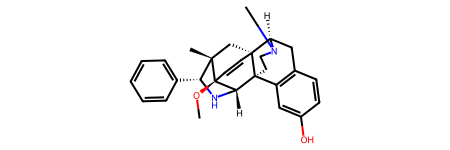

In [19]:
query = ligand_agonist  

Chem.MolFromSmiles(query)

In [29]:
def query_pubchem_for_similar_compounds(smiles, threshold=75, n_records=100):
    """
    Query PubChem for similar compounds and return the job key.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.
    threshold : int
        The threshold of similarity, default 75%. In PubChem, the default threshold is 90%.
    n_records : int
        The maximum number of feedback records.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    return key

In [30]:
job_key = query_pubchem_for_similar_compounds(query)

In [31]:
def check_and_download(key, attempts=30):
    """
    Check job status and download PubChem CIDs when the job finished

    Parameters
    ----------
    key : str
        The job key of the PubChem service.
    attempts : int
        The time waiting for the feedback from the PubChem service.

    Returns
    -------
    list
        The PubChem CIDs of similar compounds.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
    print(f"Querying for job {key} at URL {url}...", end="")
    while attempts:
        r = requests.get(url)
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    else:
        raise ValueError(f"Could not find matches for job key: {key}")
    return cids

In [32]:
similar_cids = check_and_download(job_key)

Querying for job 2896274290793496113 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/2896274290793496113/cids/JSON...

In [33]:
def smiles_from_pubchem_cids(cids):
    """
    Get the canonical SMILES string from the PubChem CIDs.

    Parameters
    ----------
    cids : list
        A list of PubChem CIDs.

    Returns
    -------
    list
        The canonical SMILES strings of the PubChem CIDs.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]

In [34]:
similar_smiles = smiles_from_pubchem_cids(similar_cids)

,smiles,CIDs,ROMol
0,CC1C2CC3=C(C1(CCN2CC=C(C)C)C)C=C(C=C3)O,441278,
1,CN1CCC23CCCCC2C1CC4=C3C=C(C=C4)OC,5362449,
2,CN1CCC23CCCCC2C1CC4=C3C=C(C=C4)OC,5360696,
3,C=CCN1CCC23CCCCC2C1CC4=C3C=C(C=C4)O,5359371,
4,CN1CCC23CCCCC2C1CC4=C3C=C(C=C4)O,5359272,
...,...,...,...
95,CC1C2CC3=C(C1(CCN2CC=C)C)C=C(C=C3)O.Cl,13286168,
96,CC1C2CC3=C(C1(CCN2)C)C=C(C=C3)O,12371111,
97,CC1C2CC3=C(C1(CCN2)C)C=C(C=C3)O,12371110,
98,COC1=C(C=C2CCNC3C2=C1C4=CC=CC=C4C3)O,12308663,

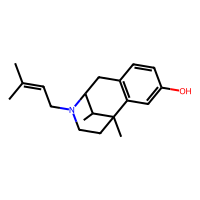
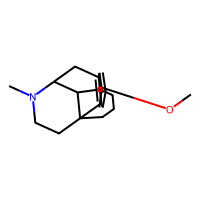
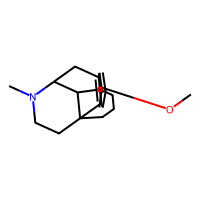
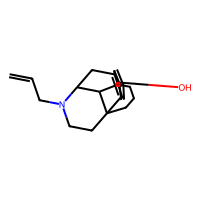
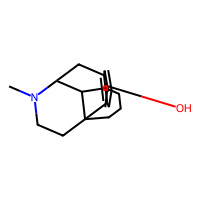
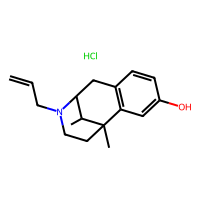
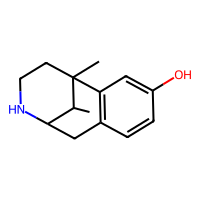
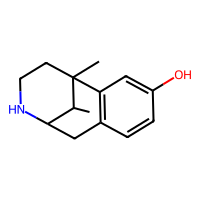
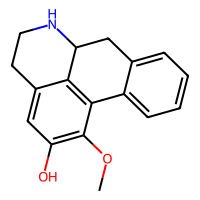
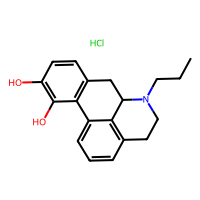

In [35]:
query_results_df = pd.DataFrame({"smiles": similar_smiles, "CIDs": similar_cids})
PandasTools.AddMoleculeColumnToFrame(query_results_df, smilesCol="smiles")
query_results_df.head(20)

query_results_df.to_csv("query_results.csv")


query_results_df


In [37]:
def multi_preview_smiles(query_smiles, query_name, similar_molecules_pd):
    """
    Show query and similar compounds in 2D structure representation.

    Parameters
    ----------
    query_smiles : str
        The SMILES string of query compound.
    query_name : str
        The name of query compound.
    similar_molecules_pd : pandas
        The pandas DataFrame which contains the SMILES string and CIDs of similar molecules.

    Returns
    -------
    MolsToGridImage
    """

    legends = [f"PubChem CID: {str(s)}" for s in similar_molecules_pd["CIDs"].tolist()]
    molecules = [Chem.MolFromSmiles(s) for s in similar_molecules_pd["smiles"]]
    query_smiles = Chem.MolFromSmiles(query_smiles)
    return MolsToGridImage(
        [query_smiles] + molecules,
        molsPerRow=3,
        subImgSize=(300, 300),
        maxMols=len(molecules),
        legends=([query_name] + legends),
        useSVG=True,
    )

The results of querying similar compounds for agonist VF1:


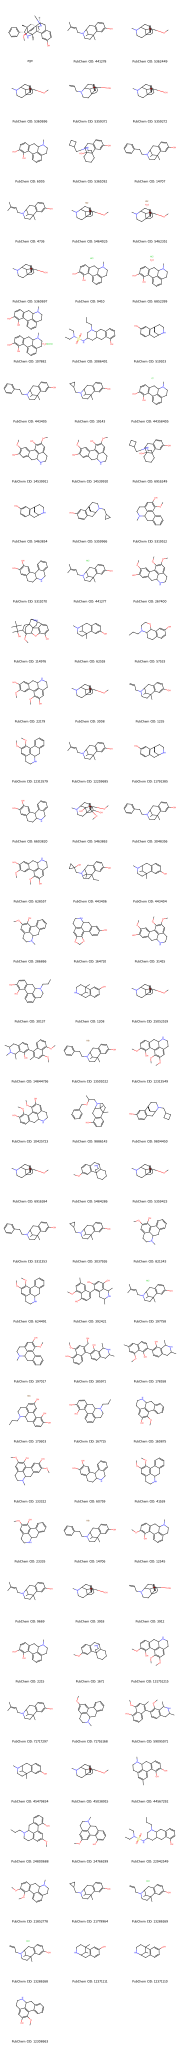

In [38]:
print("The results of querying similar compounds for agonist VF1:")
img = multi_preview_smiles(query, "ago", query_results_df)
img